In [1]:
import pandas as pd
import numpy as np
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [2]:
# Carregando os dados
train_data = pd.read_csv(r"C:\Users\arthu\Downloads\train.csv")
test_data = pd.read_csv(r"C:\Users\arthu\Downloads\test.csv")

**PassengerId**: É um identificador numérico único para cada passageiro. Normalmente, é apenas uma coluna de índice que não tem relação com a sobrevivência de uma pessoa.

**Survived**: É a variável alvo que estamos tentando prever. É um indicador binário (0 ou 1), onde 1 significa que o passageiro sobreviveu ao naufrágio do Titanic, e 0 significa que não sobreviveu.

**Pclass**: Refere-se à classe de bilhete do passageiro, que é um proxy para o status socioeconômico. Pclass é uma variável categórica com valores 1, 2 ou 3, onde 1 é a primeira classe (mais alta), 2 é a segunda classe, e 3 é a terceira classe (mais baixa).

**Name**: O nome do passageiro. Esta coluna contém os nomes completos, incluindo títulos e às vezes outros detalhes como o nome da esposa ou pais. Esses dados podem ser usados para engenharia de características adicionais, como extrair títulos para modelar o status social ou determinar relações familiares.

**Sex**: O gênero do passageiro, normalmente listado como 'male' (masculino) ou 'female' (feminino). Esta é uma característica categórica importante, pois havia uma política de "mulheres e crianças primeiro" para os botes salva-vidas.

**Age**: Idade do passageiro. Pode ser um valor inteiro ou fracionário. A idade é uma variável contínua e pode precisar de tratamento para valores faltantes, pois nem todas as idades são conhecidas.

**SibSp**: Esta coluna representa o número de irmãos/cônjuges a bordo. SibSp é a abreviação de "Siblings and Spouse". O alto número nesta coluna pode indicar que o passageiro estava viajando com a família.

**Parch**: Similar ao SibSp, esta coluna representa o número de pais/filhos a bordo. Parch é a abreviação de "Parents and Children". Valores altos podem indicar famílias viajando juntas.

**Fare**: Tarifa paga pelo passageiro. Este é um valor contínuo que varia dependendo da classe de cabine e outras possíveis fatores como promoções, último minuto de compra, ou acompanhamento de crianças. Pode estar relacionado ao Pclass, mas não é idêntico, pois passageiros na mesma classe podem ter pago tarifas diferentes.

**Embarked**: O porto no qual o passageiro embarcou no Titanic. Existem três valores possíveis: 'C' para Cherbourg, 'Q' para Queenstown (hoje conhecida como Cobh), e 'S' para Southampton.

In [3]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Estatísticas descritivas
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
# Verificar valores faltantes
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### Tratamento de Dados e criação de novas variáveis

In [6]:
# Descartando características não necessárias
train_data.drop(['Ticket' ,'PassengerId'], axis=1, inplace=True)
test_data.drop([])

### Name

In [7]:
# Usando expressões regulares para extrair o título do nome
train_data['Title'] = train_data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Substituir títulos raros por um termo mais comum ou por 'Outros'
title_mapping = {"Mlle": "Miss", "Mme": "Mrs", "Ms": "Miss", "Dr": "Rare", "Rev": "Rare", "Col": "Rare", "Major": "Rare", "Sir": "Rare", "Lady": "Rare", "Capt": "Rare", "Countess": "Rare", "Jonkheer": "Rare"}

train_data['Title'] = train_data['Title'].replace(title_mapping)

# One-hot encoding dos títulos
titles_dummies = pd.get_dummies(train_data['Title'], prefix='Title')
train_data = pd.concat([train_data, titles_dummies], axis=1)

### Sex

In [8]:
# Codificando variáveis categóricas
train_data['Sex'] = train_data['Sex'].map({'male': 0, 'female': 1})

### Age

In [9]:
# Preenchendo valores faltantes
train_data['Age'].fillna(train_data['Age'].median(), inplace=True)

bins = [0, 13, 19, 65, np.inf]
names = ['child', 'teenager', 'adult', 'senior']
train_data['AgeGroup'] = pd.cut(train_data['Age'], bins, labels=names)

# One-hot encoding dos grupos de idade
age_dummies = pd.get_dummies(train_data['AgeGroup'], prefix='Age')
train_data = pd.concat([train_data, age_dummies], axis=1)

# Normalização
min_max_scaler = MinMaxScaler()
train_data['Age'] = min_max_scaler.fit_transform(train_data['Age'].values.reshape(-1, 1))

### Fare

In [10]:
# Adicionar 1 para evitar log(0) que é indefinido
train_data['Fare'] = np.log(train_data['Fare'] + 1)

# Criando uma nova coluna para 'Fare' por 'Pclass'
train_data['FarePclass'] = train_data['Fare'] * train_data['Pclass']

# Criando uma nova coluna para 'Fare' por 'Age'
train_data['FareAge'] = train_data['Fare'] * train_data['Age']

# Criando uma nova coluna para 'Fare' por 'SibSp' (número de irmãos/cônjuges a bordo)
train_data['FareSibSp'] = train_data['Fare'] * train_data['SibSp']

# Criando uma nova coluna para 'Fare' por 'Parch' (número de pais/filhos a bordo)
train_data['FareParch'] = train_data['Fare'] * train_data['Parch']

# Criando uma nova coluna para 'Fare' por pessoa (dividindo pela soma de 'SibSp', 'Parch' + 1)
train_data['FarePerPerson'] = train_data['Fare'] / (train_data['SibSp'] + train_data['Parch'] + 1)

# Agora, vamos criar uma coluna que combina 'FarePerPerson' e 'Age'
train_data['FarePerPersonAge'] = train_data['FarePerPerson'] * train_data['Age']

### Cabin

In [11]:
train_data['CabinKnown'] = train_data['Cabin'].apply(lambda x: 0 if pd.isna(x) else 1)

# Extrair o deck das cabines
train_data['Deck'] = train_data['Cabin'].apply(lambda x: x[0] if pd.notna(x) else 'U')  # 'U' para desconhecido

# Contar o número de cabines
train_data['NumCabins'] = train_data['Cabin'].apply(lambda x: len(x.split()) if pd.notna(x) else 0)

# tratar decks como categorias numéricas
decks = train_data['Deck'].unique().tolist()
deck_mapping = {deck: idx for idx, deck in enumerate(decks)}
train_data['Deck'] = train_data['Deck'].map(deck_mapping)

### Embarked

In [12]:
# Converter 'Embarked' para numérico S = 0, C = 1, Q = 2
train_data['Embarked'] = train_data['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

### Outros

In [13]:
train_data['FamilySize'] = train_data['SibSp'] + train_data['Parch'] + 1

train_data['IsAlone'] = (train_data['FamilySize'] == 1).astype(int)

train_data['WomanOrChild'] = ((train_data['Sex'] == 1) | (train_data['Age'] < 18)).astype(int)

train_data['Age*Class'] = train_data['Age'] * train_data['Pclass']
train_data['Age*IsAlone'] = train_data['Age'] * train_data['IsAlone']

# Elevando 'Age' e 'Pclass' ao quadrado
train_data['Age^2'] = train_data['Age'] ** 2
train_data['Pclass^2'] = train_data['Pclass'] ** 2

# Criando interações entre 'Age' e 'Pclass'
train_data['Age*Pclass'] = train_data['Age'] * train_data['Pclass']
train_data['Age^2*Pclass'] = train_data['Age^2'] * train_data['Pclass']
train_data['Age*Pclass^2'] = train_data['Age'] * train_data['Pclass^2']

# Elevando 'Fare' e 'FamilySize' ao quadrado
train_data['Fare^2'] = train_data['Fare'] ** 2
train_data['FamilySize^2'] = train_data['FamilySize'] ** 2

# Criando interações entre 'Fare' e 'FamilySize'
train_data['Fare*FamilySize'] = train_data['Fare'] * train_data['FamilySize']
train_data['Fare^2*FamilySize'] = train_data['Fare^2'] * train_data['FamilySize']
train_data['Fare*FamilySize^2'] = train_data['Fare'] * train_data['FamilySize^2']

# Outras interações polinomiais
train_data['Age*IsAlone'] = train_data['Age'] * train_data['IsAlone']
train_data['FarePerPerson^2'] = train_data['FarePerPerson'] ** 2
train_data['FareAge*Pclass'] = train_data['FareAge'] * train_data['Pclass']


### Após treinar o modelo foi verificado quais features eram mais importantes, então vamos remover as menos importantes aqui

In [14]:
# Remover colunas desnecessárias

train_data.drop(['Name', 'Cabin', 'Title', 'AgeGroup','Age','Fare','Title_Don','Age_child','Age_adult','Age_senior',
                 'FarePerPerson','CabinKnown','Age_teenager','Age*IsAlone','FarePerPersonAge',
                 'FareAge','FarePclass','Age^2','Title_Rare','Age*Pclass','IsAlone','FareParch',
                 'FareAge*Pclass','Age*Class','Embarked','NumCabins','Pclass','SibSp'], axis=1, inplace=True)


In [15]:
# remover NaN
train_data.dropna(inplace=True)

In [16]:
X = train_data.drop('Survived', axis=1)
y = train_data['Survived']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# listar os indices das features em x_train junto com o nome
features = X_train.columns
features

Index(['Sex', 'Parch', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'FareSibSp', 'Deck', 'FamilySize', 'WomanOrChild', 'Pclass^2',
       'Age^2*Pclass', 'Age*Pclass^2', 'Fare^2', 'FamilySize^2',
       'Fare*FamilySize', 'Fare^2*FamilySize', 'Fare*FamilySize^2',
       'FarePerPerson^2'],
      dtype='object')

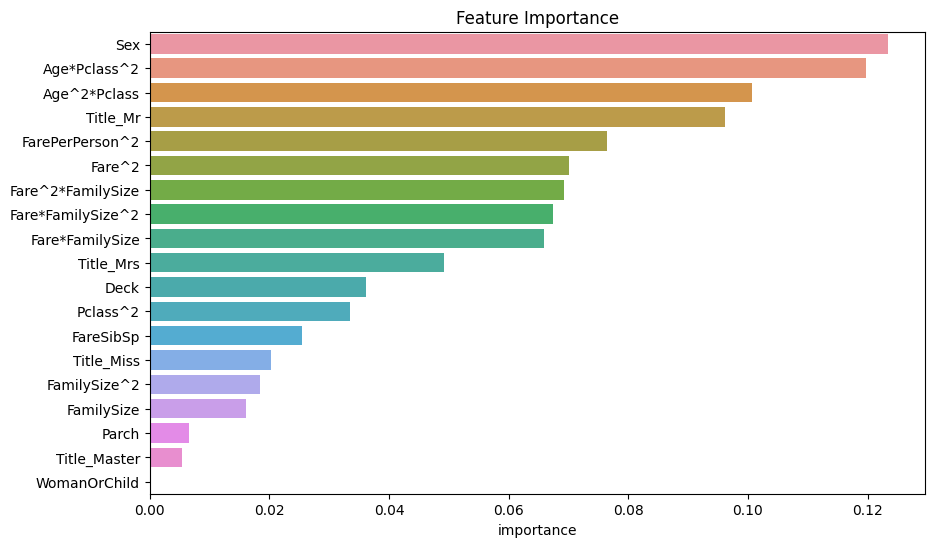

In [18]:
# criar uma randomforest para verificar feature importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Verificar a importância das características
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

# Plotar as importâncias das características
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y=feature_importances.index, data=feature_importances)
plt.title('Feature Importance')
plt.show()


In [19]:
X_val = X_val.to_numpy()
y_val = y_val.to_numpy().reshape(-1, 1)
X_train = X_train.to_numpy()
y_train = y_train.to_numpy().reshape(-1, 1)
y_train.shape

(712, 1)

In [20]:
X_train.shape

(712, 19)

In [21]:
X_train = X_train.T
y_train = y_train.T
X_val = X_val.T
y_val = y_val.T

In [22]:
X_train.shape

(19, 712)

In [23]:
y_train.shape

(1, 712)

# Rede neural

### Inicialização de parâmetros

**np.random.seed(3)**: Esta linha é usada para garantir que a função gere os mesmos números aleatórios cada vez que é executada. Isso é útil para a reprodutibilidade dos resultados. O número `3` é apenas um número arbitrário que serve como semente (seed).

**parameters = {}**: Cria um dicionário vazio chamado `parameters`. Este dicionário será usado para armazenar os pesos e os vieses da rede neural.

**L = len(layer_dims)**: Aqui, `L` é o número total de camadas na rede, incluindo a camada de entrada e a camada de saída. O parâmetro `layer_dims` é uma lista que contém o número de neurônios em cada camada da rede.

**for l in range(1, L)**: Este é um loop que itera sobre todas as camadas da rede (exceto a camada de entrada, daí começamos de `1` e não de `0`). Para cada camada, ele inicializa os parâmetros `W` (pesos) e `b` (vieses).

**parameters['W' + str(l)]**: Para cada camada `l`, inicializa uma matriz de pesos `W`. Os pesos são inicializados aleatoriamente com uma distribuição normal (gaussiana). A linha `np.random.randn(layer_dims[l], layer_dims[l-1])` cria uma matriz com dimensões especificadas pela camada atual `l` e pela camada anterior `l-1`. O fator `0.01` é usado para manter os pesos pequenos, ajudando a evitar problemas com gradientes muito grandes no início do treinamento.

**parameters['b' + str(l)]**: Similarmente, para cada camada `l`, inicializa um vetor de vieses `b`. Os vieses são inicializados com zeros. A expressão `np.zeros((layer_dims[l], 1))` cria um vetor coluna com `layer_dims[l]` elementos, todos iguais a zero.

In [24]:
def initialize_parameters_deep(layer_dims):
   
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)  

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

    return parameters

### Combinação linear

**A**: A saída(ativação) da camada anterior (ou os dados de entrada para a primeira camada oculta). É uma matriz onde cada coluna representa um exemplo de treinamento e cada linha um neurônio da camada anterior.

**W**: A matriz de pesos associada à camada atual. As dimensões desta matriz dependem do número de neurônios na camada atual (definido pelo número de linhas) e no número de neurônios na camada anterior (definido pelo número de colunas).

**b**: O vetor de viés associado à camada atual. Sua dimensão é igual ao número de neurônios na camada atual e é adicionado a cada unidade de saída antes da aplicação da função de ativação.

A operação realizada pela função é descrita pela seguinte equação matemática:

$$ Z = W \cdot A + b $$

Onde:
- **Z**: O resultado da operação linear, que é a entrada para a função de ativação da camada atual. Este é um vetor ou matriz que representa a combinação linear das entradas com os pesos e os viéses.
- **cache**: Um tuplo que armazena os valores de A, W, e b. Esses valores são armazenados para serem utilizados posteriormente durante a retropropagação (backpropagation), pois serão necessários para calcular os gradientes dos pesos e viéses.


In [25]:
def linear_forward(A, W, b):
  
    Z = np.dot(W, A) + b
    cache = (A, W, b)
    
    return Z, cache

### Funções de ativação

In [26]:
# Implementa a função de ativação Sigmoid
def sigmoid(Z):
    A = 1 / (1 + np.exp(-Z))
    cache = Z
    return A, cache

# Implementa a função de ativação ReLU
def relu(Z):
    A = np.maximum(0, Z)
    cache = Z
    return A, cache


# Implementa a função de ativação Softmax
def softmax(Z):
    expZ = np.exp(Z - np.max(Z, axis=0, keepdims=True))
    A = expZ / (np.sum(expZ, axis=0, keepdims=True) + 1e-8)
    cache = Z
    return A, cache

# Implementa a função de ativação Linear
def linear_activation(Z):
   
    A = Z
    cache = Z
    return A, cache

### Computação das ativações

- **A_prev**: A ativação da camada anterior ou os dados de entrada para a primeira camada oculta.
- **W**: A matriz de pesos associada à camada atual.
- **b**: O vetor de viés associado à camada atual.
- **activation**: Uma string que especifica a função de ativação a ser utilizada ("sigmoid" ou "relu").
- **keep_prob**: A probabilidade de manter um neurônio ativo durante dropout; um valor de 1 significa que o dropout não é aplicado, enquanto valores menores que 1 ativam o dropout.

Etapas realizadas pela função:
1. **Operação Linear**: Primeiro, a função realiza a operação linear usando os parâmetros `A_prev`, `W`, e `b` através da chamada à função `linear_forward`, resultando em `Z` e armazenando os valores intermediários em `linear_cache`.

2. **Aplicação da Função de Ativação**: Dependendo do valor do parâmetro `activation`, a função `sigmoid` ou `relu` é aplicada a `Z`. O resultado dessa operação é armazenado em `A` (ativação da camada atual), e os valores intermediários são armazenados em `activation_cache`.

3. **Aplicação de Dropout** (se `keep_prob` < 1): Uma matriz `D` é gerada com dimensões iguais a `A`, onde cada elemento é selecionado aleatoriamente para ser 0 (neurônio desativado) ou 1 (neurônio ativado) com base em `keep_prob`. `A` é então multiplicado por `D` para desativar aleatoriamente alguns neurônios e escalado por `keep_prob` para manter a expectativa do valor de ativação inalterada.

4. **Retorno dos Resultados**: A função retorna `A`, a ativação da camada atual após aplicação da função de ativação e do dropout (se aplicável), juntamente com `cache`, que contém `linear_cache`, `activation_cache`, e `D` (o último é `None` se `keep_prob` = 1, ou seja, sem dropout).

In [27]:
def linear_activation_forward(A_prev, W, b, activation, keep_prob=1):
    Z, linear_cache = linear_forward(A_prev, W, b)

    if activation == "sigmoid":
        A, activation_cache = sigmoid(Z)
    elif activation == "relu":
        A, activation_cache = relu(Z)

    D = None
    if keep_prob < 1:
        D = np.random.rand(A.shape[0], A.shape[1]) < keep_prob
        A = A * D
        A = A / keep_prob

    cache = (linear_cache, activation_cache, D)

    return A, cache

### Foward propagation

- **X**: A matriz de entrada para a rede, onde cada coluna representa um exemplo de treinamento.
- **parameters**: Um dicionário contendo os parâmetros "W" e "b" para cada camada da rede.
- **hidden_activation**: A função de ativação a ser usada nas camadas ocultas. Geralmente, "relu" é usada por sua eficácia em evitar o problema do gradiente desaparecendo em redes profundas.
- **output_activation**: A função de ativação a ser usada na camada de saída, escolhida com base no tipo de problema (e.g., "sigmoid" para classificação binária, "softmax" para classificação multiclasse).
- **keep_prob**: A probabilidade de manter um neurônio ativo durante o dropout nas camadas ocultas. Um valor de 1 significa que o dropout não é aplicado.

Processo da função:
1. **Inicializações**: Uma lista `caches` é inicializada para armazenar caches de cada camada, e `A` é inicialmente definido como `X` (a entrada para a primeira camada).
2. **Iteração pelas Camadas Ocultas**: Para cada camada oculta (`for l in range(1, L)`), a função `linear_activation_forward` é chamada com a ativação da camada anterior (`A_prev`), os parâmetros da camada atual (`W[l]`, `b[l]`), a função de ativação `hidden_activation`, e `keep_prob`. O resultado (ativação da camada atual) é armazenado em `A`, e o cache correspondente é adicionado à lista `caches`.
3. **Camada de Saída**: Após processar todas as camadas ocultas, a função `linear_activation_forward` é chamada mais uma vez para a camada de saída, usando a ativação da última camada oculta como entrada e a função de ativação `output_activation`. Nesta etapa, `keep_prob` é definido como 1 para desabilitar o dropout.
4. **Retorno dos Resultados**: A função retorna `AL` (a ativação da última camada, que representa as previsões da rede) e `caches` (contendo todos os caches das camadas para uso na retropropagação).


In [28]:
def L_model_forward(X, parameters, hidden_activation='relu', output_activation='sigmoid', keep_prob=1):
    caches = []
    A = X
    L = len(parameters) // 2
    
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(
            A_prev, 
            parameters['W' + str(l)], 
            parameters['b' + str(l)], 
            activation=hidden_activation, 
            keep_prob=keep_prob
        )
        caches.append(cache)
    
    AL, cache = linear_activation_forward(
        A, 
        parameters['W' + str(L)], 
        parameters['b' + str(L)], 
        activation=output_activation, 
        keep_prob=1
    )
    caches.append(cache)
    
    return AL, caches

### Função de custo

- **AL**: A ativação da última camada da rede neural, que contém as previsões do modelo.
- **Y**: Os rótulos verdadeiros dos dados de treinamento.
- **parameters**: Um dicionário contendo os parâmetros "W" e "b" de cada camada da rede.
- **lambd**: O hiperparâmetro de regularização L2. Um valor de `0` significa que não há regularização.
- **problema**: Uma string que indica o tipo de problema que a rede está tentando resolver: 'regressao', 'classificacao_binaria', ou 'classificacao_multiclasse'.

Processo da função:
1. **Cálculo do Custo Base**:
   - Para **classificação binária**, é calculada a entropia cruzada binária entre as previsões (`AL`) e os rótulos verdadeiros (`Y`), adicionando `epsilon` para evitar o logaritmo de zero.
   - Para **regressão**, é usado o erro quadrático médio entre `AL` e `Y`.
   - Para **classificação multiclasse**, é calculada a entropia cruzada, adequada para problemas com mais de duas classes.

2. **Cálculo do Custo de Regularização L2**:
   - É calculada a soma dos quadrados de todos os pesos (`W`) da rede, multiplicada pelo hiperparâmetro de regularização `lambd` e dividida por `2*m` (onde `m` é o número de exemplos de treinamento). Esse termo adiciona um custo proporcional à magnitude dos pesos, incentivando o modelo a manter os pesos pequenos.

3. **Combinação dos Custos**:
   - O custo total é a soma do custo base (entropia cruzada ou erro quadrático médio) e o custo de regularização L2. Esse custo total é usado para avaliar o quão bem o modelo está se ajustando aos dados enquanto mantém os pesos sob controle para evitar o overfitting.


In [29]:
def compute_cost(AL, Y, parameters, lambd=0, problema='regressao'):
   
    m = Y.shape[1]
    cross_entropy_cost = 0
    if problema == 'classificacao_binaria':
        cross_entropy_cost = -(1./m) * (np.dot(Y, np.log(AL + 1e-8).T) + np.dot(1-Y, np.log(1-AL + 1e-8).T))
    elif problema == 'regressao':
        cross_entropy_cost = (1./m) * np.sum(np.square(AL - Y))
    elif problema == 'classificacao_multiclasse':
        cross_entropy_cost = -(1./m) * np.sum(Y * np.log(AL + 1e-8))
    
    cross_entropy_cost = np.squeeze(cross_entropy_cost)  # Garante que o custo seja um escalar.

    # Calcula o custo de regularização L2
    L = len(parameters) // 2  # Número de camadas na rede
    L2_regularization_cost = 0

    for l in range(1, L + 1):
        L2_regularization_cost += np.sum(np.square(parameters["W" + str(l)]))
    
    L2_regularization_cost = (lambd / (2 * m)) * L2_regularization_cost

    # Soma o custo de entropia cruzada (ou erro quadrático médio) e o custo de regularização
    cost = cross_entropy_cost + L2_regularization_cost
    
    return cost

### Computção dos gradientes

- **dZ**: O gradiente do custo em relação à saída linear (Z) da camada atual.
- **cache**: Uma tupla contendo `A_prev` (as ativações da camada anterior), `W` (os pesos da camada atual), e `b` (o viés da camada atual). Estes valores foram armazenados durante a propagação para frente para serem utilizados na retropropagação.
- **lambd**: O hiperparâmetro de regularização L2, que adiciona uma penalidade aos pesos para evitar overfitting.

Processo da função:
1. **Recuperação do cache**: Extrai `A_prev`, `W`, e `b` do cache para utilizá-los no cálculo dos gradientes.
   
2. **Cálculo do gradiente dos pesos (dW)**:
   - O gradiente dos pesos é calculado como a média do produto dot entre `dZ` e a transposta de `A_prev`. Essa operação reflete como o custo muda com relação a uma mudança nos pesos.
   - A regularização L2 é aplicada ao gradiente dos pesos, adicionando `(lambd/m) * W` ao gradiente. Isso penaliza pesos grandes, contribuindo para a prevenção do overfitting.
   
3. **Cálculo do gradiente do viés (db)**:
   - O gradiente do viés é calculado como a média da soma de `dZ` ao longo de suas colunas (exemplos de treinamento). Isso indica como o custo muda com uma mudança no viés.
   
4. **Cálculo do gradiente em relação à ativação da camada anterior (dA_prev)**:
   - O gradiente em relação à ativação da camada anterior é obtido pelo produto dot entre a transposta dos pesos (`W.T`) e `dZ`. Isso reflete como o custo muda com relação às ativações da camada anterior, permitindo que a retropropagação continue para a próxima camada anterior no processo de backpropagation.


In [30]:
def linear_backward(dZ, cache, lambd):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1/m) * np.dot(dZ, A_prev.T) + (lambd/m) * W 
    db = (1/m) * np.sum(dZ, axis=1, keepdims=True) 
    dA_prev = np.dot(W.T, dZ) 

    return dA_prev, dW, db

### Derivadas das funções de ativação

In [31]:
def sigmoid_backward(dA, cache):
    
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s) 
    return dZ

def relu_backward(dA, cache):
    
    Z = cache
    dZ = np.array(dA, copy=True) 
    dZ[Z <= 0] = 0 
    return dZ


def softmax_backward(dA, cache):
   
    dZ = dA * (1 - dA) 
    return dZ

### Computação dos gradientes das funções de ativação

- **dA**: O gradiente do custo em relação à ativação da camada atual.
- **cache**: Contém três componentes principais:
  - **linear_cache**: Armazena os valores de `A_prev`, `W`, e `b` da propagação para frente.
  - **activation_cache**: Guarda os valores de `Z`, a saída linear antes da aplicação da função de ativação.
  - **D**: Matriz de dropout que indica quais neurônios foram mantidos durante a propagação para frente.
- **activation**: Indica a função de ativação usada na camada ("relu" ou "sigmoid").
- **lambd**: O hiperparâmetro de regularização L2.
- **keep_prob**: A probabilidade de manter um neurônio ativo durante o dropout.

Processo da função:

1. **Aplicação do Dropout**:
   - Se `keep_prob` é menor que 1, o gradiente `dA` é ajustado para refletir apenas os neurônios ativos durante a propagação para frente. Isso é feito multiplicando `dA` pela matriz `D` e dividindo pelo `keep_prob`. Este passo assegura que apenas os gradientes dos neurônios ativos são passados para trás.

2. **Cálculo do Gradiente da Função de Ativação (dZ)**:
   - Dependendo da função de ativação usada, calcula-se o gradiente `dZ` da função de ativação com relação a `Z` (armazenado em `activation_cache`). Para "relu", utiliza-se `relu_backward`, e para "sigmoid", `sigmoid_backward`.

3. **Cálculo dos Gradientes Lineares (dA_prev, dW, db)**:
   - Com o `dZ` obtido, chama-se a função `linear_backward` para calcular os gradientes em relação à ativação da camada anterior (`dA_prev`), os pesos (`dW`), e os vieses (`db`). A regularização L2 é aplicada nesse passo para os pesos.


In [32]:
def linear_activation_backward(dA, cache, activation, lambd, keep_prob):
    linear_cache, activation_cache, D = cache

    if keep_prob < 1:
        dA = dA * D
        dA = dA / keep_prob

    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)

    dA_prev, dW, db = linear_backward(dZ, linear_cache, lambd)

    return dA_prev, dW, db

### Backpropagation

- **AL**: A última saída de ativação da propagação para frente, equivalente às previsões do modelo.
- **Y**: Os rótulos verdadeiros do conjunto de dados.
- **caches**: Uma lista que contém os caches de cada camada, armazenados durante a propagação para frente. Cada cache contém informações necessárias para a retropropagação naquela camada específica.
- **lambd**: O hiperparâmetro de regularização L2.
- **keep_prob**: A probabilidade de manter um neurônio ativo durante o dropout.
- **hidden_activation**: A função de ativação usada nas camadas ocultas ("relu", por exemplo).
- **output_activation**: A função de ativação usada na camada de saída ("sigmoid", por exemplo, para classificação binária).
- **problema**: O tipo de problema sendo resolvido ("classificacao_binaria" nesse caso).

Processo da função:

1. **Inicialização**:
   - Prepara o dicionário `grads` para armazenar os gradientes calculados.
   - Redimensiona `Y` para que tenha o mesmo formato que `AL`.
   - Se estiver resolvendo uma classificação binária, ajusta `AL` para evitar divisão por zero durante o cálculo do gradiente `dAL`.

2. **Gradientes da Camada de Saída**:
   - Calcula o gradiente da ativação da última camada (`dAL`) com base na diferença entre as previsões (`AL`) e os rótulos verdadeiros (`Y`).
   - Usa `linear_activation_backward` para calcular os gradientes da última camada, considerando a função de ativação de saída e sem aplicar dropout (`keep_prob=1`).

3. **Retropropagação pelas Camadas Ocultas**:
   - Itera pelas camadas ocultas em ordem reversa, usando o gradiente da ativação da camada seguinte (`dA_prev_temp`) e o cache da camada atual para calcular os gradientes com `linear_activation_backward`.
   - Neste processo, aplica-se o dropout conforme especificado por `keep_prob` e a regularização L2 conforme `lambd`.

4. **Armazenamento dos Gradientes**:
   - Os gradientes calculados (`dA_prev`, `dW`, `db`) para cada camada são armazenados no dicionário `grads`.


In [33]:
def L_model_backward(AL, Y, caches, lambd, keep_prob, hidden_activation='relu', output_activation='sigmoid', problema='classificacao_binaria'):
    grads = {}
    L = len(caches)
    Y = Y.reshape(AL.shape)
    
    if problema == 'classificacao_binaria':   
        epsilon = 1e-8
        AL = np.clip(AL, epsilon, 1-epsilon)
        dAL = -(np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    current_cache = caches[L-1]
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(
        dAL, 
        current_cache, 
        output_activation, 
        lambd, 
        keep_prob=1
    )
    grads["dA" + str(L-1)] = dA_prev_temp
    grads["dW" + str(L)] = dW_temp
    grads["db" + str(L)] = db_temp
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(
            grads["dA" + str(l+1)], 
            current_cache, 
            hidden_activation, 
            lambd, 
            keep_prob
        )
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

### Atualização dos parâmetros

**Parâmetros da função:**

- **params**: Dicionário contendo os parâmetros atuais da rede, ou seja, os pesos (`W`) e os vieses (`b`) de cada camada.
- **grads**: Dicionário contendo os gradientes dos parâmetros calculados pela retropropagação. Inclui os gradientes dos pesos (`dW`) e dos vieses (`db`) para cada camada.
- **learning_rate**: Taxa de aprendizado utilizada para ponderar o tamanho do passo na atualização dos parâmetros.

**Processo da função:**

1. **Cópia Profunda dos Parâmetros**: Uma cópia profunda (`deepcopy`) dos parâmetros é criada para evitar alterações diretas no dicionário original durante a atualização. Isso garante que os cálculos sejam realizados com base nos valores originais dos parâmetros no início da iteração.

2. **Atualização dos Parâmetros**:
   - A função itera sobre cada camada da rede (desde a primeira até a última camada, cujo número é determinado por `L`).
   - Para cada camada `l`, os pesos `W[l]` são atualizados subtraindo o produto da taxa de aprendizado (`learning_rate`) pelo gradiente correspondente dos pesos (`dW[l]`). Esse cálculo é realizado para ajustar os pesos na direção que minimiza a função de custo.
   - De maneira similar, os vieses `b[l]` são atualizados subtraindo o produto da taxa de aprendizado pelo gradiente correspondente dos vieses (`db[l]`).

3. **Retorno dos Parâmetros Atualizados**: Após a atualização de todos os parâmetros, o dicionário `parameters` é retornado. Este contém os valores atualizados de pesos e vieses para todas as camadas, que serão utilizados na próxima iteração do processo de treinamento.

In [34]:
def update_parameters(params, grads, learning_rate=0.001):
  
    parameters = copy.deepcopy(params)
    L = len(parameters) // 2  # Número de camadas na rede neural

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]

    return parameters

### Inicialização do ADAM

**Detalhes da função:**

- **parameters**: Dicionário contendo os parâmetros da rede neural (`W` e `b` para cada camada). É utilizado para determinar a forma dos vetores de momento que serão inicializados.
- **L**: Calcula o número total de camadas na rede neural pela metade do tamanho do dicionário `parameters`, já que cada camada possui um conjunto de pesos `W` e um conjunto de vieses `b`.
- **v**: Dicionário destinado a armazenar os momentos de primeira ordem (médias móveis dos gradientes) dos parâmetros. Inicializa-se com matrizes de zeros com as mesmas dimensões que os pesos `W` e os vieses `b` de cada camada.
- **s**: Dicionário destinado a armazenar os momentos de segunda ordem (médias móveis do quadrado dos gradientes) dos parâmetros. Da mesma forma que `v`, inicializa-se com matrizes de zeros correspondentes às dimensões de `W` e `b` de cada camada.

**Processo da função:**

1. Itera sobre cada camada `l` da rede neural, começando da primeira camada até a última (`L`).
2. Para cada camada, inicializa-se `v["dW" + str(l)]` e `v["db" + str(l)]` com matrizes de zeros que correspondem às dimensões de `W[l]` e `b[l]`, respectivamente. Essas matrizes armazenarão os momentos de primeira ordem para os gradientes dos pesos e vieses.
3. De forma semelhante, inicializa-se `s["dW" + str(l)]` e `s["db" + str(l)]` com matrizes de zeros para armazenar os momentos de segunda ordem dos gradientes dos pesos e vieses.
4. A função retorna os dicionários `v` e `s`, que serão utilizados nas iterações subsequentes do algoritmo Adam para ajustar adaptativamente as taxas de aprendizado dos parâmetros durante o treinamento.

In [35]:
def initialize_adam(parameters) :
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    s = {}
    
    # Initialize v, s. Input: "parameters". Outputs: "v, s".
    for l in range(1, L + 1):
        v["dW" + str(l)] = np.zeros((parameters["W" + str(l)].shape))
        v["db" + str(l)] = np.zeros((parameters["b" + str(l)].shape))
        s["dW" + str(l)] = np.zeros((parameters["W" + str(l)].shape))
        s["db" + str(l)] = np.zeros((parameters["b" + str(l)].shape))
    
    return v, s

### Atualização dos parâmetros com ADAM

**Parâmetros da função:**
- **parameters**: Dicionário contendo os parâmetros atuais do modelo (`W` e `b` para cada camada).
- **grads**: Dicionário contendo os gradientes dos parâmetros (`dW` e `db` para cada camada) obtidos na retropropagação.
- **v**: Dicionário contendo as médias móveis estimadas dos gradientes (momentos de primeira ordem).
- **s**: Dicionário contendo as médias móveis estimadas dos quadrados dos gradientes (momentos de segunda ordem).
- **t**: Número da iteração atual (usado para correção de bias).
- **learning_rate**: Taxa de aprendizado.
- **beta1**: Hiperparâmetro para estimativa do momento de primeira ordem (usualmente próximo a 0.9).
- **beta2**: Hiperparâmetro para estimativa do momento de segunda ordem (usualmente próximo a 0.999).
- **epsilon**: Termo adicionado para melhorar a estabilidade numérica (evitar divisão por zero).

**Funcionamento:**
1. **Atualização dos Momentos (v e s)**: Para cada parâmetro (`W` e `b`), a função atualiza os momentos de primeira e segunda ordem com base nos gradientes atuais. Isto é feito usando uma combinação dos valores anteriores de `v` e `s` e os novos gradientes, ponderada pelos hiperparâmetros `beta1` e `beta2`.
   
2. **Correção de Bias nos Momentos (v_corrected e s_corrected)**: Os momentos corrigidos são calculados dividindo os momentos pelos fatores de correção `(1 - beta1^t)` e `(1 - beta2^t)`, respectivamente. Isto corrige o bias inicial dos momentos, que é mais significativo nas primeiras iterações.

3. **Atualização dos Parâmetros**: Os parâmetros são atualizados subtraindo um valor proporcional ao momento de primeira ordem corrigido (`v_corrected`) e normalizado pelo momento de segunda ordem corrigido (`s_corrected`), ajustado pela raiz quadrada e pelo valor de `epsilon`. A taxa de aprendizado é aplicada a essa quantidade para determinar a magnitude da atualização.

**Retorno:**
- **parameters**: Dicionário contendo os parâmetros atualizados.
- **v**: Dicionário atualizado com os novos momentos de primeira ordem.
- **s**: Dicionário atualizado com os novos momentos de segunda ordem.

In [36]:
def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):

    
    L = len(parameters) // 2                
    v_corrected = {}                      
    s_corrected = {}                         
    
  
    for l in range(1, L + 1):
        
        v["dW" + str(l)] = beta1 * v["dW" + str(l)] + (1 - beta1) * grads['dW' + str(l)]
        v["db" + str(l)] = beta1 * v["db" + str(l)] + (1 - beta1) * grads['db' + str(l)]

        v_corrected["dW" + str(l)] = v["dW" + str(l)] / (1 - beta1 ** t)
        v_corrected["db" + str(l)] = v["db" + str(l)] / (1 - beta1 ** t)
       
        s["dW" + str(l)] = beta2 * s["dW" + str(l)] + (1 - beta2) * (grads['dW' + str(l)] ** 2)
        s["db" + str(l)] = beta2 * s["db" + str(l)] + (1 - beta2) * (grads['db' + str(l)] ** 2)

        s_corrected["dW" + str(l)] = s["dW" + str(l)] / (1 - beta2 ** t)
        s_corrected["db" + str(l)] = s["db" + str(l)] / (1 - beta2 ** t)

        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * (v_corrected["dW" + str(l)] / (np.sqrt(s_corrected["dW" + str(l)]) + epsilon))
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * (v_corrected["db" + str(l)] / (np.sqrt(s_corrected["db" + str(l)]) + epsilon))
        

    return parameters, v, s

# Treinamento

In [37]:
# Defina as dimensões de cada camada (incluindo a camada de entrada e a camada de saída)
layer_dims = [X_train.shape[0], 16, y_train.shape[0]]  

# Inicialize os parâmetros
parameters = initialize_parameters_deep(layer_dims)

v, s = initialize_adam(parameters)

# Número de iterações para o treinamento
num_iterations = 10000000
learning_rate = 0.00001

# Para problemas de classificação multiclasse
problema = 'classificacao_binaria' 

costs_train = []
accuracies_train = []
costs_val = []
accuracies_val = []

t = 0

for i in range(0, num_iterations):
    t += 1  # Incrementa o contador para o Adam
    
    # Propagação para frente
    AL, caches = L_model_forward(X_train, parameters, hidden_activation='relu', output_activation='sigmoid', keep_prob=0.5)
    
    # Propagação pra frente nos dados de validação
    AL_val, _ = L_model_forward(X_val, parameters, hidden_activation='relu', output_activation='sigmoid')

    # Cálculo do custo
    cost = compute_cost(AL, y_train, parameters, lambd=0.1, problema='classificacao_binaria')
    costs_train.append(cost)  # Armazena o custo
    
    # Custo nos dados de validação
    cost_val = compute_cost(AL_val, y_val, parameters, lambd=0.1, problema='classificacao_binaria')
    costs_val.append(cost_val) 

    # Cálculo da acurácia
    predictions = AL > 0.5
    accuracy = np.mean(predictions == y_train) * 100
    accuracies_train.append(accuracy)  # Armazena a acurácia

    # Acurácia nos dados de validação
    predictions_val = AL_val > 0.5
    accuracy_val = np.mean(predictions_val == y_val) * 100
    accuracies_val.append(accuracy_val)
    
    # Retropropagação
    grads = L_model_backward(AL, y_train, caches, lambd=0.1, keep_prob = 0.5, hidden_activation='relu', output_activation='sigmoid', problema='classificacao_binaria')
    
    # Atualização dos parâmetros com Adam
    parameters, v, s = update_parameters_with_adam(parameters, grads, v, s, t, learning_rate)
    
    if i % 100 == 0:  # Imprimir o custo e a acurácia a cada 100 iterações
        print(f"Iteração {i}: Custo Treino = {cost:.6f}, Acurácia Treino = {accuracy:.2f}%, Custo Validação = {cost_val:.6f}, Acurácia Validação = {accuracy_val:.2f}%")

    if cost_val <= 0.412:
        break


Iteração 0: Custo Treino = 0.693563, Acurácia Treino = 47.05%, Custo Validação = 0.693589, Acurácia Validação = 33.52%
Iteração 100: Custo Treino = 0.692293, Acurácia Treino = 57.30%, Custo Validação = 0.693140, Acurácia Validação = 58.66%
Iteração 200: Custo Treino = 0.690986, Acurácia Treino = 62.92%, Custo Validação = 0.692610, Acurácia Validação = 58.66%
Iteração 300: Custo Treino = 0.689779, Acurácia Treino = 61.94%, Custo Validação = 0.692089, Acurácia Validação = 58.66%
Iteração 400: Custo Treino = 0.688194, Acurácia Treino = 62.64%, Custo Validação = 0.691522, Acurácia Validação = 58.66%
Iteração 500: Custo Treino = 0.686687, Acurácia Treino = 62.64%, Custo Validação = 0.690683, Acurácia Validação = 58.66%
Iteração 600: Custo Treino = 0.683608, Acurácia Treino = 62.50%, Custo Validação = 0.689652, Acurácia Validação = 58.66%
Iteração 700: Custo Treino = 0.682377, Acurácia Treino = 62.78%, Custo Validação = 0.688230, Acurácia Validação = 58.66%
Iteração 800: Custo Treino = 0.681

Iteração 1400: Custo Treino = 0.668150, Acurácia Treino = 62.78%, Custo Validação = 0.677108, Acurácia Validação = 58.66%
Iteração 1500: Custo Treino = 0.664499, Acurácia Treino = 63.76%, Custo Validação = 0.674881, Acurácia Validação = 58.66%
Iteração 1600: Custo Treino = 0.663219, Acurácia Treino = 64.04%, Custo Validação = 0.672507, Acurácia Validação = 58.66%
Iteração 1700: Custo Treino = 0.664260, Acurácia Treino = 63.48%, Custo Validação = 0.670050, Acurácia Validação = 59.22%
Iteração 1800: Custo Treino = 0.660201, Acurácia Treino = 63.48%, Custo Validação = 0.667422, Acurácia Validação = 59.78%
Iteração 1900: Custo Treino = 0.655683, Acurácia Treino = 66.01%, Custo Validação = 0.664769, Acurácia Validação = 60.89%
Iteração 2000: Custo Treino = 0.654521, Acurácia Treino = 65.87%, Custo Validação = 0.661995, Acurácia Validação = 62.01%
Iteração 2100: Custo Treino = 0.651386, Acurácia Treino = 64.47%, Custo Validação = 0.659141, Acurácia Validação = 63.69%
Iteração 2200: Custo Tre

In [39]:
# Usar o modelo para fazer previsões nos dados de teste
AL_test, _ = L_model_forward(test_data, parameters, hidden_activation='relu', output_activation='sigmoid', keep_prob=1)

# Converter as probabilidades de sobrevivência em previsões binárias
predictions_test = (AL_test > 0.5).astype(int)

# Criar um DataFrame para a submissão
submission = pd.DataFrame({
    "PassengerId": test_data["PassengerId"],
    "Survived": predictions_test.ravel() 
})

# Salvar o DataFrame como um arquivo csv para submissão
submission.to_csv("submission.csv", index=False)


ValueError: shapes (16,19) and (418,11) not aligned: 19 (dim 1) != 418 (dim 0)

In [ ]:
def evaluate(X, y, parameters):
    AL, _ = L_model_forward(X, parameters, hidden_activation='relu', output_activation='sigmoid', keep_prob=1)
    predictions = AL > 0.5
    accuracy = np.mean(predictions == y) * 100
    return accuracy

def feature_importance_analysis(X, y, parameters, num_runs=50):
    base_accuracy = evaluate(X, y, parameters)  # Avalia a acurácia base
    feature_importances = np.zeros(X.shape[0])

    for run in range(num_runs):
        np.random.seed(run)  # Define uma semente para garantir reprodutibilidade entre as execuções
        for i in range(X.shape[0]):  # Itera sobre as características
            X_permuted = X.copy()
            # Embaralha os valores dentro da i-ésima característica
            np.random.shuffle(X_permuted[i, :])
            permuted_accuracy = evaluate(X_permuted, y, parameters)
            # Calcula a diferença na acurácia devido ao embaralhamento e acumula
            feature_importances[i] += (base_accuracy - permuted_accuracy)

    # Calcula a média da importância ao longo de todas as execuções
    feature_importances /= num_runs

    # Imprime a importância de cada característica
    for i, importance in enumerate(feature_importances):
        print(f"Feature {i} Importance: {importance}")

feature_importance_analysis(X_train, y_train, parameters)


Feature 0 Importance: 7.519662921348311
Feature 1 Importance: 0.1264044943820187
Feature 2 Importance: 2.9803370786516825
Feature 3 Importance: 2.1713483146067385
Feature 4 Importance: 1.8904494382022445
Feature 5 Importance: 3.143258426966288
Feature 6 Importance: 1.067415730337075
Feature 7 Importance: 0.5477528089887613
Feature 8 Importance: 0.5814606741573002
Feature 9 Importance: 0.0
Feature 10 Importance: 1.4803370786516832
Feature 11 Importance: 0.011235955056178
Feature 12 Importance: 1.2387640449438178
Feature 13 Importance: 1.8398876404494364
Feature 14 Importance: 2.4382022471910085
Feature 15 Importance: 2.4606741573033677
Feature 16 Importance: 3.255617977528084
Feature 17 Importance: 3.17696629213483
Feature 18 Importance: 1.1516853932584241


In [ ]:
features[11]

'Age^2*Pclass'

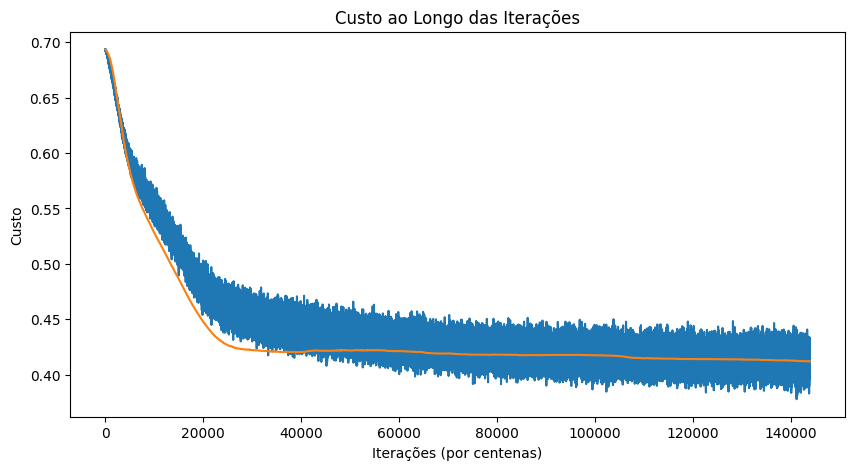

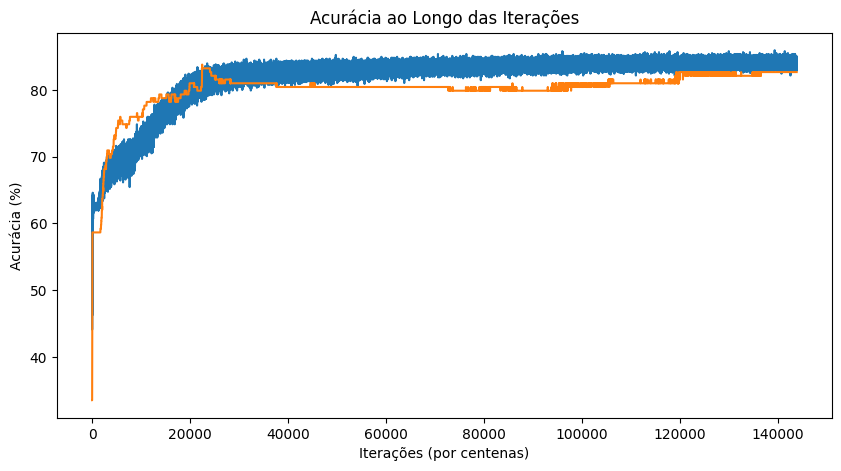

In [ ]:
import matplotlib.pyplot as plt

# Plotar o custo
plt.figure(figsize=(10, 5))
plt.plot(costs_train, label='Treino')
plt.plot(costs_val, label='Validação')
plt.title("Custo ao Longo das Iterações")
plt.xlabel("épocas")
plt.ylabel("Custo")
plt.show()

# Plotar a acurácia
plt.figure(figsize=(10, 5))
plt.plot(accuracies_train, label='Treino')
plt.plot(accuracies_val, label='Validação')
plt.title("Acurácia ao Longo das Iterações")
plt.xlabel("épocas")
plt.ylabel("Acurácia (%)")
plt.show()
